### In this project, we will attempt to use LSTM RNN to model and predict black swan events such as Covid-19

Source: U.S. Census Bureau  Release: Advance Retail Sales: Clothing and Clothing Accessory Stores
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The most recent month's value of the advance estimate based on data from a subsample of firms from the larger Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/RSCCASN

Information about the Monthly Retail Trade Survey can be found on the Census website at https://www.census.gov/retail/mrts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Retail Sales: Clothing and Clothing Accessory Stores [MRTSSM448USN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MRTSSM448USN, November 29, 2021.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./MRTSSM448USN.csv', index_col='DATE', parse_dates=True)

<AxesSubplot:xlabel='DATE'>

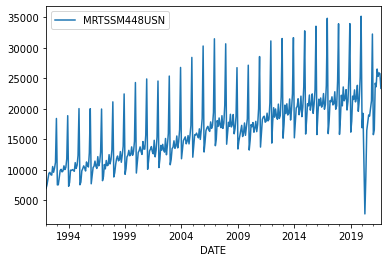

In [3]:
df.plot()

There are two noticeable dips in the trend, the first one occurring during the 08-09 financial crisis and the second around 2020 during Covid-19 pandemic.

However, the dip during the 08-09 financial crisis is not as severe as the dip during Covid-19 pandemic.
We will split the data into a training set, X and a test set, y. The training set, X, will consist of the time period up until 2019-01-01 before the onset of the pandemic and when the lockdown happened. The test set will consist of the time period from 2019-01-01 to latest current month.

In [4]:
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


(588.0, 622.0)

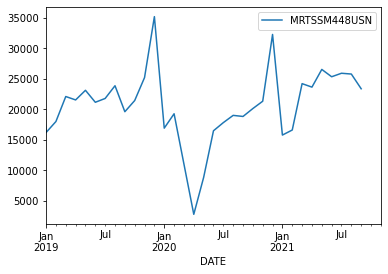

In [5]:
df.plot()
plt.xlim('2019-01-01', '2021-11-01')

We will split up the data in a training set, X, consisting of the dataset up to 2019-01-01 and a test set consisting of the dataset from 2019-01-01 to the end

In [6]:
df.tail()

,MRTSSM448USN
DATE,
2021-05-01,26503
2021-06-01,25301
2021-07-01,25874
2021-08-01,25745
2021-09-01,23330


In [7]:
# 9 months of 2021 and 12 months of 2020
test_size = 9 + 12

In [8]:
test_index = len(df) - test_size

In [9]:
X = df.iloc[:test_index]

In [10]:
y = df.iloc[test_index:]

<AxesSubplot:xlabel='DATE'>

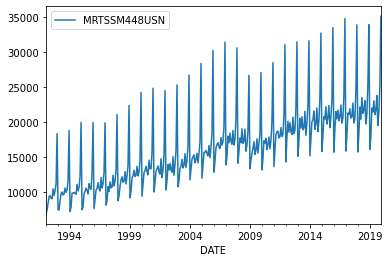

In [11]:
X.plot()

<AxesSubplot:xlabel='DATE'>

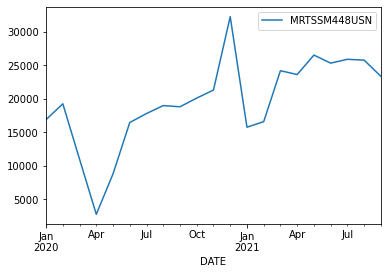

In [12]:
y.plot()

We will now scale our data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaled_X = scaler.fit_transform(X)

In [16]:
scaled_y = scaler.transform(y)

Setting up the model

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

We will pick a length of 12 since the period of each cycle is about a year

In [18]:
length = 12
generator = TimeseriesGenerator(scaled_X, scaled_X, length=length, batch_size=1)

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras import regularizers

In [97]:
n_features = 1
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [98]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 50)                10400     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

In [99]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [100]:
validation_generator = TimeseriesGenerator(scaled_y,scaled_y, length=length, batch_size=2)

In [113]:
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
324/324 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 0.1218
Epoch 2/20
324/324 [==============================] - 2s 7ms/step - loss: 0.0016 - val_loss: 0.1059
Epoch 3/20
324/324 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 0.1158
Epoch 4/20
324/324 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 0.1032
Epoch 5/20
324/324 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 0.1023
Epoch 6/20
324/324 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 0.0980
Epoch 7/20
324/324 [==============================] - 2s 7ms/step - loss: 0.0014 - val_loss: 0.1127
Epoch 8/20
324/324 [==============================] - 2s 7ms/step - loss: 9.9629e-04 - val_loss: 0.1128


In [114]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

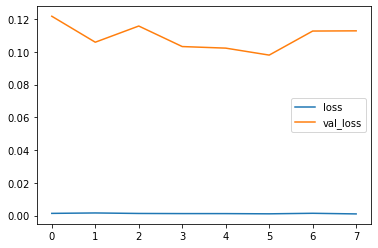

In [115]:
losses.plot()

<AxesSubplot:xlabel='DATE'>

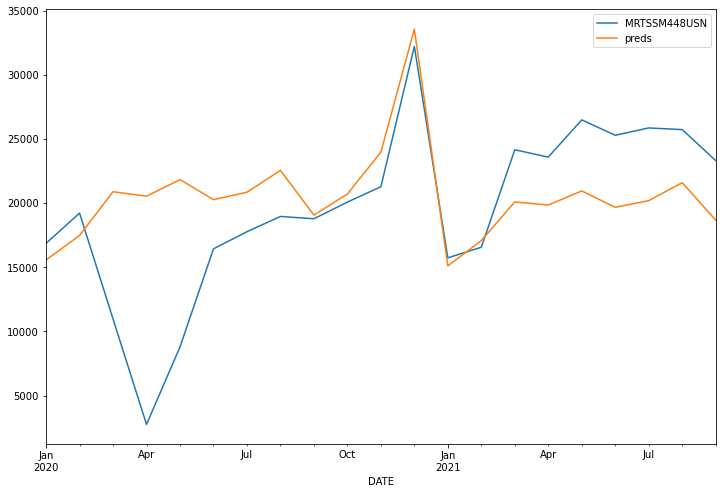

In [116]:
test_pred = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    current_pred = model.predict(current_batch)[0] #getting the number instead of the array
    test_pred.append(current_pred)
    #update batch and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

test_pred = scaler.inverse_transform(test_pred)

df_plot = y.copy()
df_plot['preds'] = test_pred
df_plot.plot(figsize=(12,8))

In the above plot, we see that the forecast prediction is unable to predict black swan events that happen unexpectedly. 

One possible solution to be able to detect black swan events:
We could compare the loss between predicted and true values of a segment of the training data.
We determine the maximum loss between the predicted and true values of the training data and use that maximum loss as a threshold. We expect the forecast predicted values past our training dataset to have an error rate within the maximum loss value. If we see a spike in error rate significantly beyond our maximum loss threshold, it could alert us to a black swan event.

Calculating the loss between predicted and true values of a segment of the training data

<AxesSubplot:xlabel='DATE'>

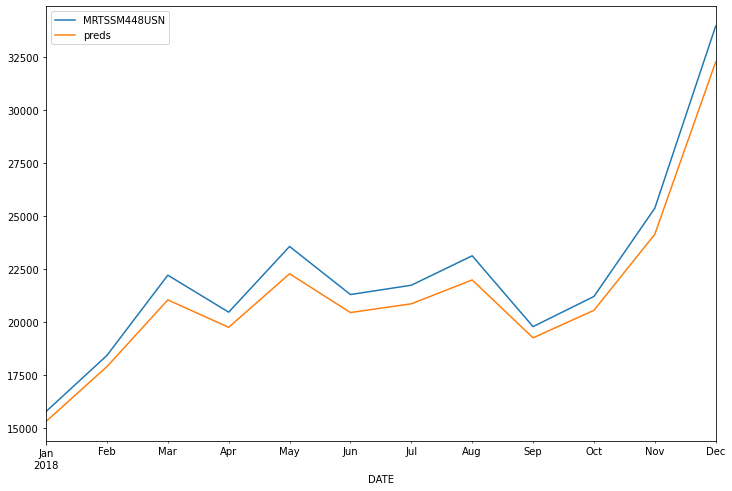

In [152]:
test_pred = []

first_eval_batch = scaled_X[-length*2:-length]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    current_pred = model.predict(current_batch)[0] #getting the number instead of the array
    test_pred.append(current_pred)
    #update batch and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

test_pred = scaler.inverse_transform(test_pred)

df_plot = X.copy()
df_plot = df_plot[-length*2:-length]
df_plot['preds'] = test_pred
df_plot.plot(figsize=(12,8))

In [153]:
scored = pd.DataFrame(index=df_plot.index)

In [154]:
scored = pd.DataFrame(index=df_plot.index)
scored['Loss'] = (np.abs(df_plot['MRTSSM448USN']-df_plot['preds']))

In [155]:
scored['Loss'].max()

1690.611794769764

The maximum loss between the predicted and true value for Jan -2018 to Dec 2018 is 1690.61. We expect that the forecast predictions and true value to vary below this threshold value

Reinitializing our forecast predictions

In [159]:
test_pred = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    current_pred = model.predict(current_batch)[0] #getting the number instead of the array
    test_pred.append(current_pred)
    #update batch and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

test_pred = scaler.inverse_transform(test_pred)

df_plot = y.copy()
df_plot['preds'] = test_pred

In [157]:
scored = pd.DataFrame(index=df_plot.index)
scored['Loss'] = (np.abs(df_plot['MRTSSM448USN']-df_plot['preds']))
scored['Threshold'] = 1690.61
scored['Anomaly'] = scored['Loss'] > scored['Threshold']

<AxesSubplot:xlabel='DATE'>

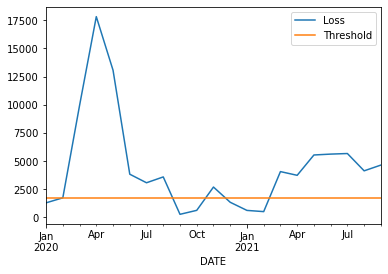

In [158]:
scored.plot()

Here, we see that in the month of March, the error between forecast and true value is almost 7,000. This would alert us that a black swan event has occurred. 